## Bloch Boundaries and Plane Waves with Angled Incidence
This notebook gives a demo of Bloch periodic boundary conditions.
As an example, we show how to set up a simulation with a plane wave with angled incidence.

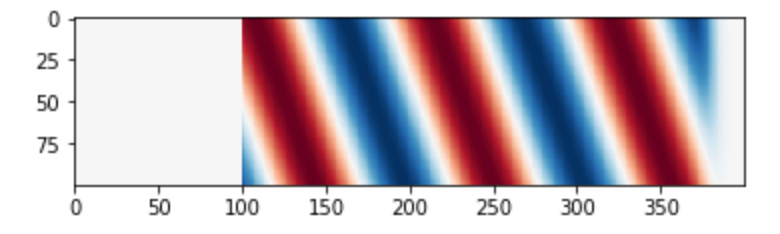


In [1]:
# import all the necessities
import numpy as np
import matplotlib.pylab as plt

from ceviche import fdfd_hz
from ceviche.constants import C_0

In [2]:
# define some constants
wavelength = 1.5e-6
omega = 2 * np.pi * C_0 / wavelength
k0 = 2 * np.pi / wavelength

dL = 1.5e-8
grid_shape = Nx, Ny = 400, 200
eps_r = np.ones(grid_shape)

source_amp = 1e-8
source_loc_x = Nx//4
npml = [40, 0]

In [3]:
# set up the FDFD
F = fdfd_hz(omega, dL, eps_r, npml)

In [4]:
# define the source as just a constant source along y at `x = source_loc_x`
source = np.zeros(grid_shape, dtype=complex)
source[source_loc_x, :] = source_amp

# add a source directly behind to cancel left traveling wave (for TFSF effect)
source[source_loc_x-1, :] = source[source_loc_x, :] * np.exp(-1j * k0 * dL - 1j * np.pi);

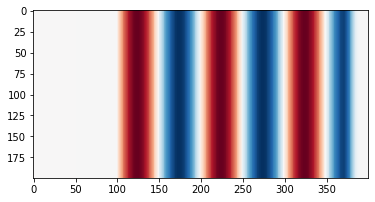

In [5]:
# solve the FDFD simulation for the fields, plot Hz
Ex, Ey, Hz = F.solve(source)
Hz_max = np.max(np.abs(Hz))        
plt.imshow(np.real(Hz.T), cmap='RdBu', vmin=-Hz_max, vmax=Hz_max)
plt.show()

We see a plane wave in x direction with wavelength 100 grid cells = `wavelength / dl` (as expected)

## Incidence Angle
Now, lets try to add an angle of incidence to this plane wave

In [6]:
angle_deg = 45   # degrees from y = 0
angle_rad = angle_deg * np.pi / 180

# compute the wave vector
kx = k0 * np.cos(angle_rad)
ky = k0 * np.sin(angle_rad)
k_vector = [kx, ky]

# get an array of the y positions across the simulation
Ly = Ny * dL
y_vec = np.linspace(-Ly / 2, Ly / 2, Ny)

make a new source where `source[y] ~ exp(i * ky * y)` to simulate an angle

In [7]:
source_amp_y = np.exp(1j * ky * y_vec)

source_angle = np.zeros(grid_shape, dtype=complex)
source_angle[source_loc_x, :] = source_amp * source_amp_y

# add another source panel directly behind to cancel the left-traveling wave
source_angle[source_loc_x-1, :] = source_angle[source_loc_x, :] * np.exp(-1j * kx * dL - 1j * np.pi);

Lets simulate our original FDTD with this new source and see what happens

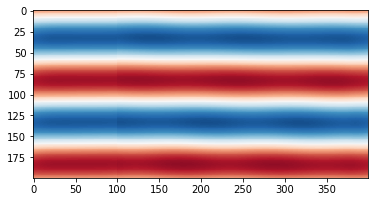

In [8]:
Ex, Ey, Hz = F.solve(source_angle)
Hz_max = np.max(np.abs(Hz))        
plt.imshow(np.real(Hz.T), cmap='RdBu', vmin=-Hz_max, vmax=Hz_max)
plt.show()

As you can see, this gives bad results because we have periodic boundary conditions in y.

When the plane wave extends across the y boundary, it should come out the other side with a phase difference to account.

We can accomplish this with **Bloch boundary conditions.**

Here we specify that the simulation is periodic but with an extra phase applied for fields jumping extending across boundaries.

In [9]:
# add a bloch phase of ky * Ly across boundary to compensate for plane wave
F_Bloch = fdfd_hz(omega, dL, eps_r, npml, bloch_phases=[0, ky * Ly])

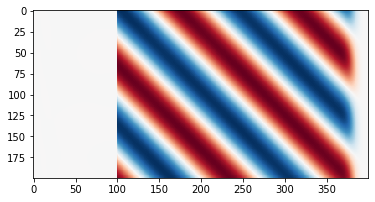

In [10]:
# now fields look as expected
Ex, Ey, Hz = F_Bloch.solve(source_angle)
Hz_max = np.max(np.abs(Hz))        
plt.imshow(np.real(Hz.T), cmap='RdBu', vmin=-Hz_max, vmax=Hz_max)
plt.show()

Now everything works as expected.